# Network Propagation and Localization Analysis of AD Genes

### Description
This notebook serves as an introduction to the Heat module of the Network Bio Toolkit to explore Alzheimer's Disease genes.

### Required Files

* Download network_bio_toolkit code: https://github.com/ucsd-ccbb/network_bio_toolkit.  Install dependencies, read documentation.

In the directory of this notebook, create a folder `data` containing the following files:
1. Download Agora targets list (under Nominated Targets): https://agora.ampadportal.org/genes/  
2. Download AD-by-proxy FUMA GWAS genes:  https://www.nature.com/articles/s41588-018-0311-9  (Table S13).
3. Download the .gpickle file to set up the local heat network. 

## Set Up Environment

In [100]:
import sys
import os

# import matplotlib
# matplotlib.use('TkAgg')

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns

# import community

# import mygene
# mg = mygene.MyGeneInfo()

# latex rendering of text in graphs
import matplotlib as mpl
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

%matplotlib inline

# import visJS2jupyter.visJS_module
# import visJS2jupyter.visualizations

Locate the path to the `network_bio_toolkit` and import the `Heat` and `imp` modules.
    Import `Heat3` if Jupyter Notebook is using `Python3`, or import `Heat2` if Jupyter Notebook is using `Python2`.

In [101]:
# locate the path based on where you installed the network_bio_toolkit
toolkit_path = os.path.join(os.environ['HOMEPATH'], 'AppData', 'Roaming', 'Python', 'Python36', 'site-packages', 'network_bio_toolkit')

sys.path.append(toolkit_path)

import Heat3
import imp

imp.reload(Heat3)

<module 'Heat3' from '\\Users\\nathantsai\\AppData\\Roaming\\Python\\Python36\\site-packages\\network_bio_toolkit\\Heat3.py'>

## Load the AD genes

Nominated target list: https://agora.ampadportal.org/genes/(genes-router:genes-list)
(suggested by Chi Hua).

1. We first locate the path of the AD Targets file in our `data` folder.
2. Then we create a pandas dataframe with the file.
3. After setting the index of our dataframe to the `Gene` column, we can take a look at our AD GWAS genes dataframe.

In [102]:
# Locate AD genes list path
AD_genes_path = os.path.join('data', 'harmonized_targets_v5_20190615.csv')

# Read AD genes list into a DataFrame
AD_genes = pd.read_csv(AD_genes_path)

# Set index to 'hgnc_symbol' column
AD_genes = AD_genes.set_index('hgnc_symbol')

print("The AD Genes DataFrame contains %d genes." % len(AD_genes))
AD_genes.head()

The AD Genes DataFrame contains 607 genes.


,Source,Team,Rank,ensembl_gene_id,Target_Choice_Justification,Predicted_Therapeutic_Direction,Data_used_to_support_target_selection,data_synapseID,study,input_data
hgnc_symbol,,,,,,,,,,
IL10RA,AMP-AD,Mayo-UFL-ISB,1,ENSG00000110324,Reducing this molecules signaling has benefici...,Antagonism predicted to reduce disease progres...,Antagonism of Il10 signaling via KO or sIL10Ra...,syn17008061,Mayo,RNA
IL10,AMP-AD,Mayo-UFL-ISB,2,ENSG00000136634,Reducing this molecules signaling has benefici...,Antagonism predicted to reduce disease progres...,Increased Il10 increase amyloid and tau pathol...,syn17008061,Mayo,RNA
TLR5,AMP-AD,Mayo-UFL-ISB,3,ENSG00000187554,TLR5 binds amyloid and is implicated in immune...,Agonism predicted to reduce disease progression.,sTLR5 is validated by modeling studies as a no...,syn17008061,Mayo,RNA
CRH,AMP-AD,Mayo-UFL-ISB,4,ENSG00000147571,CRH is key central signal coordinating psychol...,Antagonism predicted to reduce disease progres...,CRHR1 may be implicated by genetics. CRH up in...,syn17008061,Mayo,RNA
CXCL10,AMP-AD,Mayo-UFL-ISB,5,ENSG00000169245,An immune activating molecule. Decreased amylo...,Agonism predicted to reduce disease progression.,Decrease amyloid in APP mice with no apparent ...,syn17008061,Mayo,RNA


## Load the <a href="https://www.nature.com/articles/s41588-018-0311-9">AD GWAS genes</a>

1. We first locate the path of the AD GWAS file in our `data` folder.
2. Then we create a pandas dataframe with the desired table.
3. After setting the index of our dataframe to the `Gene` column, we can take a look at our AD GWAS genes dataframe.

In [103]:
# Locate AD GWAS excel spreadsheet path
AD_gwas_path = os.path.join('data', '41588_2018_311_MOESM3_ESM.xlsx')

# Read AD GWAS genes list into a DataFrame
AD_gwas_df = pd.read_excel(AD_gwas_path, sheet_name='Table S13', skiprows=3)

# Set index to 'Gene' column
AD_gwas_df = AD_gwas_df.set_index('Gene')

print("The AD GWAS DataFrame contains %d genes." % len(AD_gwas_df))
AD_gwas_df.head()

The AD GWAS DataFrame contains 192 genes.


,Locus,Ensembl ID,Entrez ID,CHR,Start BP,End BP,pLI,posMap #SNPs,posMap Max CADD,eqtlMap #SNPs,...,eqtlMap Tissues,eqtlMap Direction,ciMap,ciMap Tissues,minGwasP,IndSigSNPs,TWAS P,COLOC prob,TWAS Tissue,Additional TWAS Tissues
Gene,,,,,,,,,,,,,,,,,,,,,
PPOX,1,ENSG00000143224,5498,1,161136200,161147803,0.328332,2,5.402,2,...,BIOS_eQTL_geneLevel,-,No,NaN,2.051494e-10,rs4575098,n.s.,NaN,NaN,NaN
B4GALT3,1,ENSG00000158850,8703,1,161141100,161147287,0.020823,2,5.402,2,...,BIOS_eQTL_geneLevel:v6/Cells_Transformed_fibro...,-,No,NaN,2.051494e-10,rs4575098,2.01e-08,0.039,Cells_Transformed_fibroblasts,NaN
ADAMTS4,1,ENSG00000158859,9507,1,161154098,161168846,0.005466,2,5.402,2,...,BIOS_eQTL_geneLevel:v6/Cells_Transformed_fibro...,-,No,NaN,2.051494e-10,rs4575098,1.87e-06,0.027,Cells_Transformed_fibroblasts,NaN
NDUFS2,1,ENSG00000158864,4720,1,161166894,161184185,0.997735,0,0.000,2,...,BIOS_eQTL_geneLevel:v6/Adipose_Subcutaneous:v6...,-,No,NaN,2.051494e-10,rs4575098,1.48e-10,0.998,Adipose_Subcutaneous,NaN
FCER1G,1,ENSG00000158869,2207,1,161185024,161190489,0.635846,0,0.000,2,...,BIOS_eQTL_geneLevel:v6/Adipose_Subcutaneous:v6...,-,No,NaN,2.051494e-10,rs4575098,n.s.,NaN,NaN,NaN


## Network Propagation Set Up

Set up focal genes list.

In [104]:
# Set focal genes list
focal_genes = AD_gwas_df.index.tolist() #AD_genes.index.tolist()

# Set focal gene set name
focal_geneset='AD_gwas_pos_eQTL' # 'AD_target'

print("%d focal genes." % len(focal_genes))

192 focal genes.


Write focal genes to a .tsv file.

In [105]:
# Write out seed genes for AWS processing

# pd.DataFrame({'seed_genes':[focal_genes]}).to_csv('AD_seed_genes.tsv',sep='\t')

Create Heat instance and assign focal genes list to heat DEG list.

In [106]:
# create heat instance
heat = Heat3.Heat(gene_type = 'symbol', species = 'human')

# assign DEG list
heat.DEG_list = focal_genes

Looking at the attributes of the Heat3 object instance `heat`, we can see that `gene_type` is set to `symbol`, `species` is set to `human`, and `DEG_list` is set to the `focal_genes` variable we set in a cell above.

In [107]:
print("Gene Type: %s" % heat.gene_type)
print("Species: %s" % heat.species)
print("DEG_list is focal_genes: " + str(focal_genes == heat.DEG_list))

Gene Type: symbol
Species: human
DEG_list is focal_genes: True


## Load the Interactome

In [108]:
# Set interactome
interactome='STRING700'

# Create directory to save interactome results
savedir = interactome + '_results/'
if not os.path.isdir(savedir):
    os.mkdir(savedir)

## Load Network Locally

In [109]:
# Locate gpickle file (provided in repo)
gpickle_path = os.path.join('data', 'G_str_181022.gpickle')

heat.DG_universe = nx.read_gpickle(gpickle_path)

print("Number of interactions: %d" % len(list(heat.DG_universe.edges())))

print("Number of nodes: %d" % len(list(heat.DG_universe.nodes())))

Number of interactions: 359776
Number of nodes: 15131


In [110]:
# how many genes are in the network?
print("There are %d genes in this network." % len(np.intersect1d(heat.DEG_list, heat.DG_universe.nodes())))

There are 146 genes in this network.


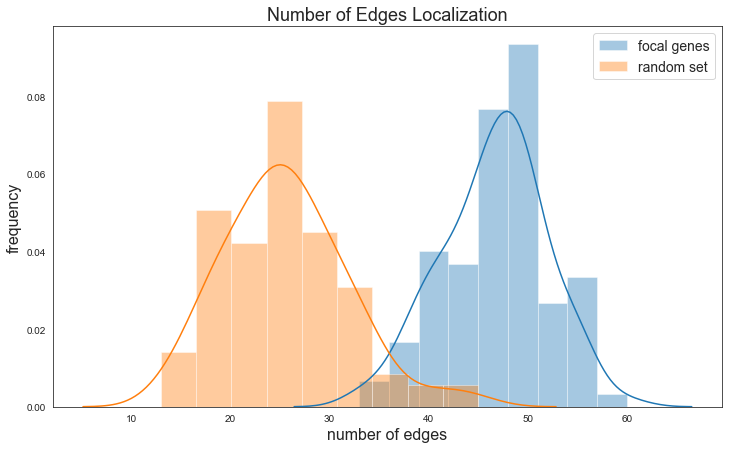

In [111]:
numedges_list, numedges_rand, LCC_list, LCC_rand = heat.localization(num_reps = 100, 
                                                                     sample_frac = 0.8, 
                                                                     method = 'numedges', 
                                                                     plot = True)

# Save graph as .png file.
# plt.savefig(savedir + '/_AD_numedges_localization' + focal_geneset + '.png', dpi=300, bbox_inches='tight')

1.0648963377768439e-08


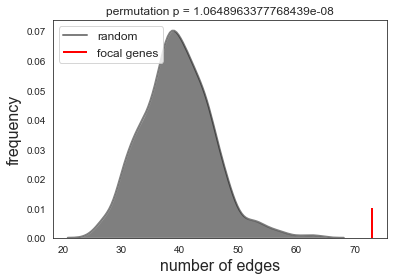

In [112]:
# test out plotting parameters with a smaller num_reps first.
numedges_list, numedges_rand, LCC_list, LCC_rand = heat.localization_full(num_reps = 1000, 
                                                                          method = 'numedges', 
                                                                          label = 'focal genes',
                                                                          line_height = 0.01,
                                                                          legend_loc = 'upper left'
                                                                         )

# Save graph as .png file.
# plt.savefig(savedir + '_AD_numedges_localization_nosamp' + focal_geneset + '.png', dpi=300, bbox_inches='tight')